In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from random import sample

## read in data

In [2]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [3]:
print(filled_1850.shape)
print(filled_1850.loc[~filled_1850['block_num'].isnull()].shape)
print(filled_1850.loc[filled_1850['block_num'].isnull()].shape)

(515630, 32)
(166500, 32)
(349130, 32)


In [4]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

In [5]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [6]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

## create sequences

In [7]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

## Visualize distance sequence

In [15]:
def plot_distance_seq(loc_df, current_seq, unique_seq, ax):
    colors = [plt.rcParams['axes.prop_cycle'].by_key()['color'][x] for x in range(len(unique_seq))]
    ax.scatter(x=loc_df.loc[:, x_col], y=loc_df.loc[:, y_col], s=10, color='grey')
    for seq, color in zip(unique_seq, colors):
        X_subset = loc_df[loc_df[current_seq] == seq]
        # graph info
        ax.plot(X_subset.loc[:, x_col], X_subset.loc[:, y_col], label=str(seq),
                   color=color)
        ax.scatter(X_subset.loc[:, x_col], X_subset.loc[:, y_col],
                   color=color, s=20)
    ax.legend()
    ax.set_title(current_seq)

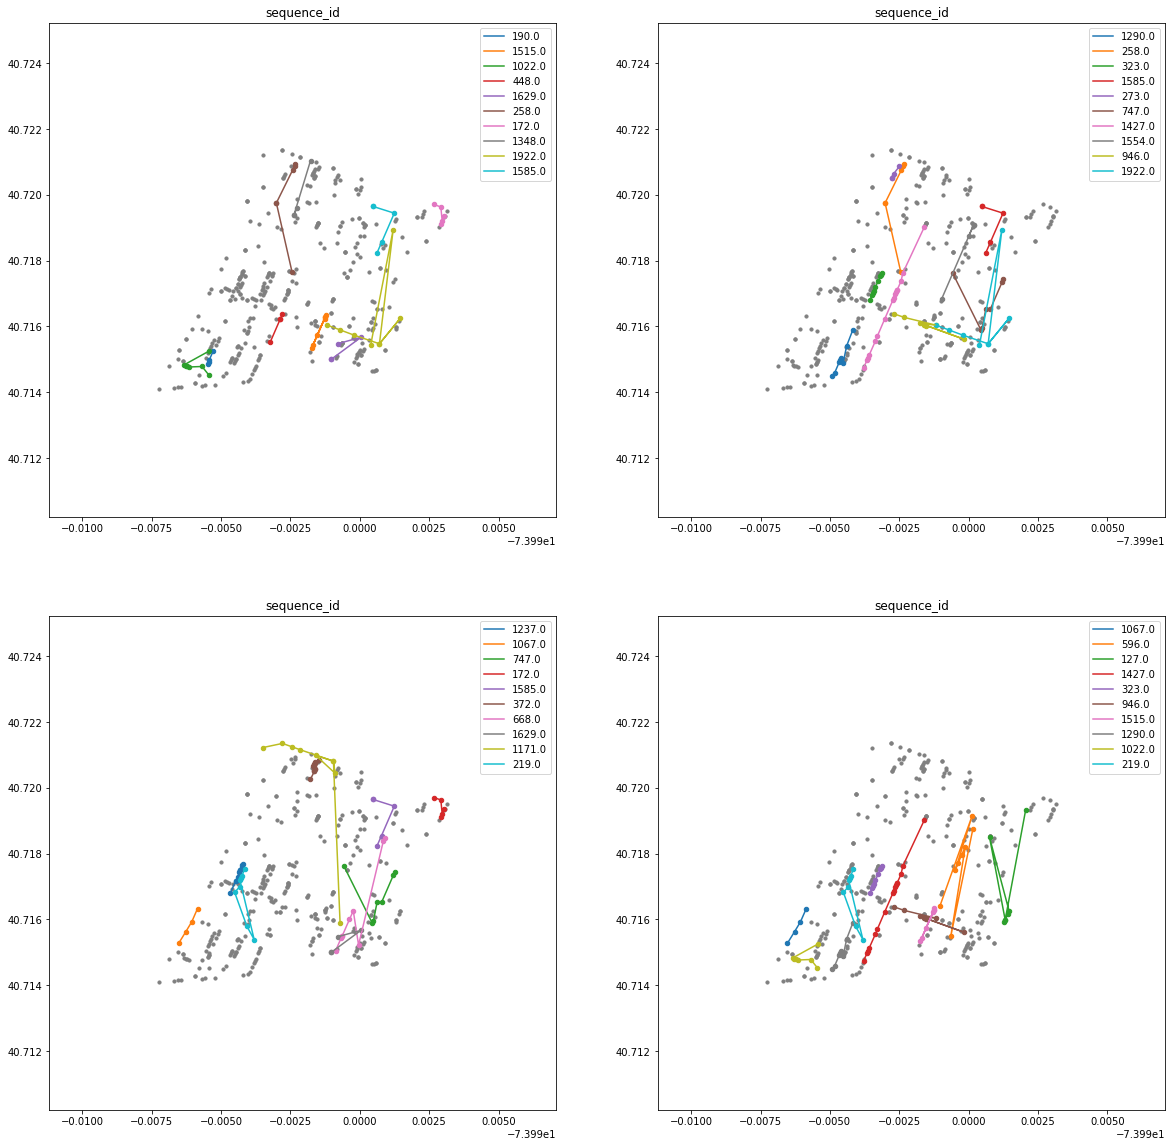

In [21]:
loc_df = census_enum_seq.df[['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'dwelling_id',
                         'sequence_id', 'fixed_seq', 'dwelling_seq_id', 'enum_dist_id']].dropna(subset=['cd_X', 'cd_Y'])\
                                    .drop_duplicates().copy()

current_seq = 'sequence_id'
seq_member_cnt = loc_df.groupby(current_seq)['block_num'].agg('count')
temp = list(seq_member_cnt.iloc[np.where(seq_member_cnt > 3)[0]].index)

fig, ax = plt.subplots(2,2, figsize=(20,20))

for i in range(2):
    for j in range(2):
        unique_seq = sample(temp, 10)
        plot_distance_seq(loc_df, current_seq, unique_seq, ax[i,j])

# Trial 2: d = 0.05

In [22]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(d=0.05, enumerator_dist = True, dwelling = True, fixed = True, distance = True)

## Visualize distance sequence

Sample some of the sequences that are longer than 3 dwellings

total num of long sequences:  27


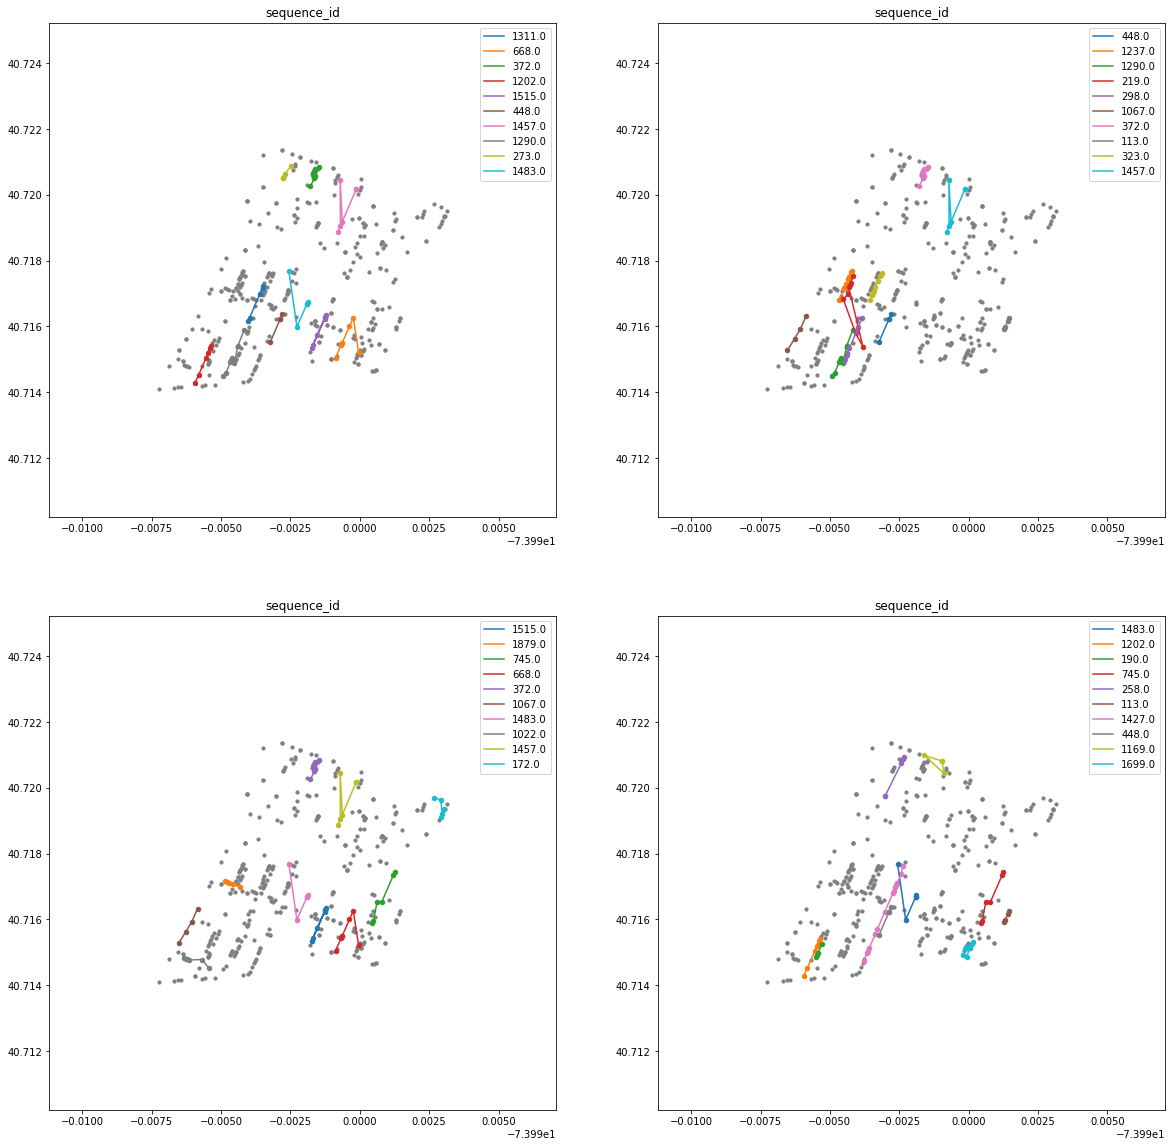

In [25]:
loc_df = census_enum_seq.df[['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'dwelling_id',
                         'sequence_id', 'fixed_seq', 'dwelling_seq_id', 'enum_dist_id']].dropna(subset=['cd_X', 'cd_Y'])\
                                    .drop_duplicates().copy()

current_seq = 'sequence_id'
seq_member_cnt = loc_df.groupby(current_seq)['block_num'].agg('count')
temp = list(seq_member_cnt.iloc[np.where(seq_member_cnt > 3)[0]].index)
print("total num of long sequences: ",len(temp))
fig, ax = plt.subplots(2,2, figsize=(20,20))

for i in range(2):
    for j in range(2):
        unique_seq = sample(temp, 10)
        plot_distance_seq(loc_df, current_seq, unique_seq, ax[i,j])

In [33]:
current_df = census_enum_seq.df[['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'dwelling_id',
                         'sequence_id', 'dist']]
current_df = current_df.loc[current_df['sequence_id'] == 1483]
pd.set_option("max_rows", None)
current_df

block_num CD_ADDRESS       cd_X       cd_Y  dwelling_id  sequence_id  \
0 17093     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17094     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17095     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17096     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17097     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17098     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17099     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17100     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17101     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17102     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17103     1269.0   51 Allen -73.991878  40.716749         1476       1483.0   
  17104     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17105     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17106     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17107     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17108     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17109     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17110     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17111     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17112     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17113     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17114     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17115     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17116     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17117     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17118     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17119     1269.0  49} Allen -73.991908  40.716686         1477       1483.0   
  17120     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17121     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17122     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17123     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17124     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17125     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17126     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17127     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17128     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17129     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17130     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17131     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17132     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17133     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17134     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17135     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17136     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17137     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17138     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17139     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17140     1269.0   49 Allen -73.991908  40.716686         1478       1483.0   
  17141     1269.0   49 Allen -73.991908

In [32]:
current_df = census_enum_seq.df[['block_num', 'CD_ADDRESS', 'cd_X', 'cd_Y', 'dwelling_id',
                         'sequence_id', 'dist']]
current_df = current_df.loc[current_df['sequence_id'] == 745]
# pd.set_option("max_rows", None)
current_df

block_num CD_ADDRESS       cd_X       cd_Y  dwelling_id  sequence_id  \
0 7922     1277.0   72 Essex -73.988744  40.717433          716        745.0   
  7923     1277.0   72 Essex -73.988744  40.717433          716        745.0   
  7924     1277.0   72 Essex -73.988744  40.717433          716        745.0   
  7925     1277.0   72 Essex -73.988744  40.717433          716        745.0   
  7926        NaN        NaN        NaN        NaN          717        745.0   
  7927        NaN        NaN        NaN        NaN          717        745.0   
  7928        NaN        NaN        NaN        NaN          717        745.0   
  7929        NaN        NaN        NaN        NaN          717        745.0   
  7930        NaN        NaN        NaN        NaN          717        745.0   
  7931        NaN        NaN        NaN        NaN          717        745.0   
  7932        NaN        NaN        NaN        NaN          717        745.0   
  7933        NaN        NaN        NaN        NaN          717        745.0   
  7934        NaN        NaN        NaN        NaN          717        745.0   
  7935     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7936     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7937     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7938     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7939     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7940     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7941     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7942     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7943     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7944     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7945     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7946     1277.0   70 Essex -73.988787  40.717355          718        745.0   
  7947        NaN        NaN        NaN        NaN          719        745.0   
  7948        NaN        NaN        NaN        NaN          719        745.0   
  7949        NaN        NaN        NaN        NaN          719        745.0   
  7950        NaN        NaN        NaN        NaN          720        745.0   
  7951        NaN        NaN        NaN        NaN          720        745.0   
  7952        NaN        NaN        NaN        NaN          720        745.0   
  7953        NaN        NaN        NaN        NaN          720        745.0   
  7954        NaN        NaN        NaN        NaN          721        745.0   
  7955        NaN        NaN        NaN        NaN          721        745.0   
  7956        NaN        NaN        NaN        NaN          721        745.0   
  7957        NaN        NaN        NaN        NaN          721        745.0   
  7958        NaN        NaN        NaN        NaN          721        745.0   
  7959        NaN        NaN        NaN        NaN          721        745.0   
  7960        NaN        NaN        NaN        NaN          721        745.0   
  7961        NaN        NaN        NaN        NaN          721        745.0   
  7962        NaN        NaN        NaN        NaN          721        745.0   
  7963        NaN        NaN        NaN        NaN          721        745.0   
  7964        NaN        NaN        NaN        NaN          721        745.0   
  7965        NaN        NaN        NaN        NaN          721        745.0   
  7966        NaN        NaN        NaN        NaN          721        745.0   
  7967        NaN        NaN        NaN        NaN          721        745.0   
  7968        NaN        NaN        NaN        NaN          721        745.0   
  7969        NaN        NaN        NaN        NaN          721        745.0   
  7970        NaN        NaN        NaN        NaN          721        745.0   
  7971  

## Conclusion

* d=0.1 is too large. There are some sequences that jump across the map. Using d=0.5 is better. 
* Most sequences are along a street so it does not matter whether we are using haversine or walking distance. The issue seems to be more with the distance threshold. 
    * However, in a few sequences, having walking distance will be very helpful in addition to setting a distance threshold
* Euclidean distance possibly works fine since each data points are very close

## Test Performance

In [34]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)


for selected_d in [0.1,0.08, 0.05, 0.035, 0.03]:
    census_enum_seq.apply_sequencing(d=selected_d,enumerator_dist = True, dwelling = True, fixed = True, distance = True)

    similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
    census_enum_seq.apply_similarity(sim_columns=similar_cols)

    all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
                "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
                "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
                "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
                "enum_dist_order"]

    transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                                  ('onehot', OneHotEncoder(handle_unknown='ignore'), ['similarity_label'])])
    # define pipeline
    pipeline = Pipeline(steps=[('preprocess', transformer), 
                               ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                           n_estimators = 50))])

    interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, pipeline, all_cols + ['similarity_label'],
                                                 KMeans(5), block_centroids)
    score, model = interpolate_sequences.kmeans_best(5)
    interpolate_sequences.set_clustering_algo(model)
    interpolate_sequences.apply_clustering(algo_fit = True)
#     interpolate_sequences.clustervis(kmeans = True)
    interpolate_sequences.cross_validate_model(k=10)
    print('Current d: ', selected_d)
    print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
    print('Test score:', interpolate_sequences.test_score)
    print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 126, cost: 3017.0
Run 1, iteration: 2/100, moves: 1, cost: 3017.0
n is 5 and it's the 10th iteration
n is 5 and it's the 20th iteration
n is 5 and it's the 30th iteration
n is 5 and it's the 40th iteration
n is 5 and it's the 50th iteration
Current d:  0.1
avg Training score: 0.9781407094634696
Test score: [0.6550802139037433, 0.6137992831541219, 0.563953488372093, 0.6357827476038339, 0.614854517611026, 0.635623869801085, 0.5301102629346904, 0.6850733390854185, 0.5747330960854092, 0.6069315300084531]
avg Test score: 0.6115942348559875
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 97, cost: 2831.0
Run 1, iteration: 2/100, moves: 0, cost: 2831.0
n is 5 and it's the 10th iteration
n is 5 and it's the 20th iteration
n is 5 and it's the 30th iteration
n is 5 and it's the 40th iteration
n is 5 and it's the 50th itera

### The CV score is best at 0.63 when d = 0.05